plotting... /scratch/da2734/twitter/jobs/training_binary/models_may20_9Klabels/output_is_unemployed/results.json
plotting... /scratch/da2734/twitter/jobs/training_binary/models_may20_9Klabels/output_lost_job_1mo/results.json
plotting... /scratch/da2734/twitter/jobs/training_binary/models_may20_9Klabels/output_job_search/results.json
plotting... /scratch/da2734/twitter/jobs/training_binary/models_may20_9Klabels/output_is_hired_1mo/results.json
plotting... /scratch/da2734/twitter/jobs/training_binary/models_may20_9Klabels/output_job_offer/results.json


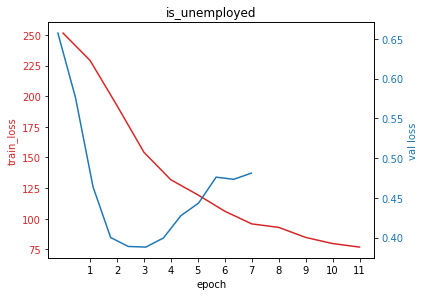

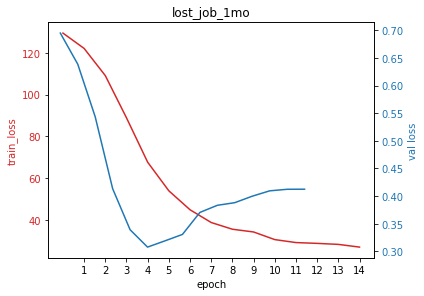

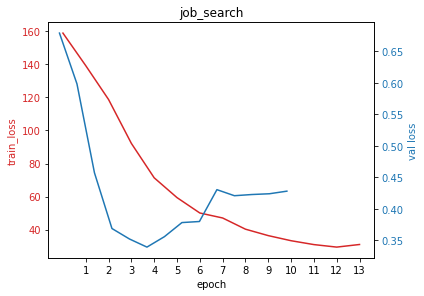

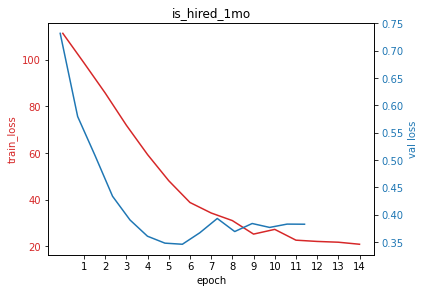

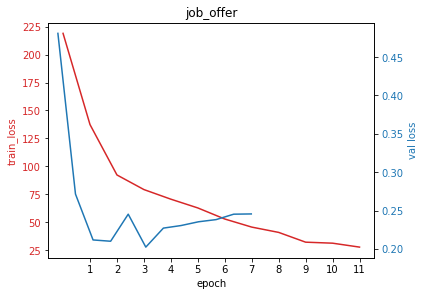

In [1]:
# plotting validation curves

import time
start_time = time.time()

import pandas as pd
import random
import numpy as np
import os

# dirs = os.listdir( './' )

counter = 0
for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:

    file = '/scratch/da2734/twitter/jobs/training_binary/models_may20_9Klabels/output_{}/results.json'.format(column)
    
    results = pd.read_json(file)

    plot_filename = file.split('.')[0]

    results = results.T

    results.index = results['epoch']
#     print(results.head())


    results = results[:20]

    print('plotting...', file)

    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('train_loss', color=color)
    ax1.plot(results['epoch'], results['train_loss'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('val loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(results['epoch'], results['loss'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    # plt.show()
    plt.xticks(np.arange(1, 19, 1.0))
    plt.title(column)

#     plt.savefig('plot_{}.png'.format(plot_filename), dpi=100)

In [3]:
#gets all this setup
import time
start_time = time.time()
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split

import datetime

import sys
sys.path.append('../')

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
# from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, accuracy
from fast_bert.metrics import *
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')



def create_model(columnm, epoch):
    
    LOG_PATH = Path('/scratch/da2734/twitter/jobs/training_binary/logs/log_binary_pos_neg_{}/'.format(column))
    print('LOG_PATH', LOG_PATH)
    DATA_PATH = Path('/scratch/da2734/twitter/data/may20_9Klabels/data_binary_pos_neg_balanced/')
    LABEL_PATH = Path('/scratch/da2734/twitter/data/may20_9Klabels/data_binary_pos_neg_balanced/')
    OUTPUT_PATH = Path('/scratch/da2734/twitter/jobs/training_binary/models_may20_9Klabels/output_{}'.format(column))
    FINETUNED_PATH = None

    args = Box({
        "run_text": "labor mturk ar 6 binary",
        "train_size": -1,
        "val_size": -1,
        "log_path": LOG_PATH,
        "full_data_dir": DATA_PATH,
        "data_dir": DATA_PATH,
        "task_name": "labor_market_classification",
        "no_cuda": False,
        #     "bert_model": BERT_PRETRAINED_PATH,
        "output_dir": OUTPUT_PATH,
        "max_seq_length": 512,
        "do_train": True,
        "do_eval": True,
        "do_lower_case": True,
        "train_batch_size": 8,
        "eval_batch_size": 16,
        "learning_rate": 5e-5,
        "num_train_epochs": 100,
        "warmup_proportion": 0.0,
        "no_cuda": False,
        "local_rank": -1,
        "seed": 42,
        "gradient_accumulation_steps": 1,
        "optimize_on_cpu": False,
        "fp16": False,
        "fp16_opt_level": "O1",
        "weight_decay": 0.0,
        "adam_epsilon": 1e-8,
        "max_grad_norm": 1.0,
        "max_steps": -1,
        "warmup_steps": 500,
        "logging_steps": 50,
        "eval_all_checkpoints": True,
        "overwrite_output_dir": True,
        "overwrite_cache": True,
        "seed": 42,
        "loss_scale": 128,
        "task_name": 'intent',
        "model_name": 'bert-base-uncased',
        "model_type": 'bert'
    })

    import logging

    logfile = str(LOG_PATH / 'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
        datefmt='%m/%d/%Y %H:%M:%S',
        handlers=[
            logging.FileHandler(logfile),
            logging.StreamHandler(sys.stdout)
        ])

    logger = logging.getLogger()

    logger.info(args)

    device = torch.device('cuda')
    if torch.cuda.device_count() > 1:
        args.multi_gpu = True
    else:
        args.multi_gpu = False

    label_cols = ['class']

    databunch = BertDataBunch(
        args['data_dir'],
        LABEL_PATH,
        args.model_name,
        train_file='train_{}.csv'.format(column),
        val_file='val_{}.csv'.format(column),
        label_file='label_{}.csv'.format(column),
        # test_data='test.csv',
        text_col="text",  # this is the name of the column in the train file that containts the tweet text
        label_col=label_cols,
        batch_size_per_gpu=args['train_batch_size'],
        max_seq_length=args['max_seq_length'],
        multi_gpu=args.multi_gpu,
        multi_label=False,
        model_type=args.model_type)

    num_labels = len(databunch.labels)
    print('num_labels', num_labels)

    print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')

    # metrics defined: https://github.com/kaushaltrivedi/fast-bert/blob/d89e2aa01d948d6d3cdea7ad106bf5792fea7dfa/fast_bert/metrics.py
    metrics = []
    # metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
    # metrics.append({'name': 'roc_auc', 'function': roc_auc})
    # metrics.append({'name': 'fbeta', 'function': fbeta})
    metrics.append({'name': 'accuracy', 'function': accuracy})
    metrics.append({'name': 'roc_auc_save_to_plot_binary', 'function': roc_auc_save_to_plot_binary})
    # metrics.append({'name': 'accuracy_multilabel', 'function': accuracy_multilabel})

    learner = BertLearner.from_pretrained_model(
        databunch,
        pretrained_path='/scratch/da2734/twitter/jobs/training_binary/models_may20_9Klabels/output_{}/model_out_{}/'.format(column, epoch), 
        metrics=metrics,
        device=device,
        logger=logger,
        output_dir=args.output_dir,
        finetuned_wgts_path=FINETUNED_PATH,
        warmup_steps=args.warmup_steps,
        multi_gpu=args.multi_gpu,
        is_fp16=args.fp16,
        multi_label=False,
        logging_steps=0)
    
    return learner

/scratch/da2734/pyenv_dval_wb_twitter/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
# histograms compute
import pickle
best_epochs = {
    'is_hired_1mo':6,
    'lost_job_1mo':4,
    'job_offer':3,
    'is_unemployed':3,
    'job_search':4
}

all_pred = {}

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start = time.time()
    trained_model = create_model(column, best_epochs[column])
    print('load model:', str(time.time() - start_time), 'seconds')
    
    start = time.time()
    val = pd.read_csv('/scratch/da2734/twitter/data/may20_9Klabels/data_binary_pos_neg_balanced/val_{}.csv'.format(column))
    print(val.shape)
    # start_time = time.time()
    texts = val['text'].values.tolist()
#     print(len(texts))
    predictions = trained_model.predict_batch(texts)
#     print(predictions)
    print('inference:', str(time.time() - start_time), 'seconds on ', len(texts), 'tweets')

    prediction_df = predictions.set_index(val.id).rename(columns={
            '0':'pos_model',
            '1':'neg_model',
    })
#     prediction_df
        
    merged = prediction_df.merge(val, on='id')
    print(merged.head())
    
    all_pred[column] = merged
#     break

# pickle.dump( all_pred, open( "./all_pred_8.1.2_undersampled-may5_7Klabels.pkl", "wb" ) )


is_unemployed


NameError: name 'create_model' is not defined

is_unemployed
lost_job_1mo
job_search
is_hired_1mo
job_offer


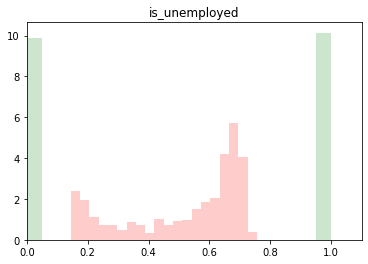

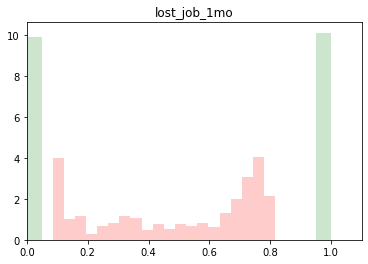

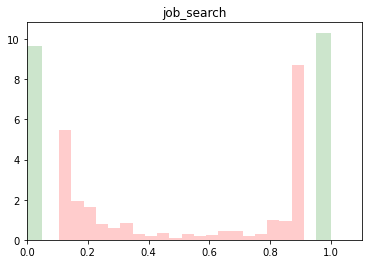

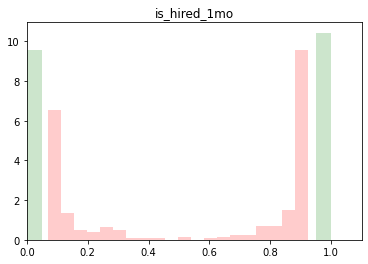

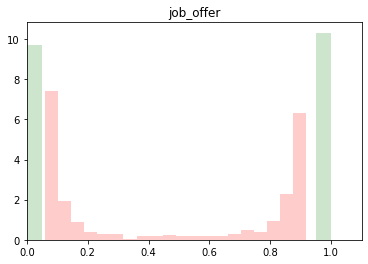

In [6]:
# histograms plot

import pickle

# with open("./all_pred_8.2.pkl", 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     all_pred = pickle.load(f)


for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    merged = all_pred[column]
    
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged['class'], bins=20, density = True, color = 'green', alpha = 0.2)
#     plt.hist(merged['neg'], bins=20, density = True, color = 'green', alpha = 0.2)

    plt.hist(merged['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
#     plt.hist(merged['neg'], bins=20, density = True, color = 'green', alpha = 0.2)
#     plt.hist(merged['neg_model'], bins=20, density = True, color = 'blue', alpha = 0.2)
#     ax.set_yscale('log')

    # plt..yscale(value)
    plt.title(column)
#     ax.legend()
    plt.xlim(0,1.1)
    
#     merged.to_csv('merged_may11_9Klabels{}.csv'.format(column))

#     plt.savefig('/scratch/da2734/twitter/mturk_mar6/data_binary/plot_{}.png'.format(column))

is_unemployed 20
is_unemployed


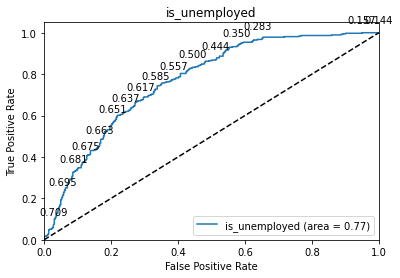

lost_job_1mo 10
lost_job_1mo


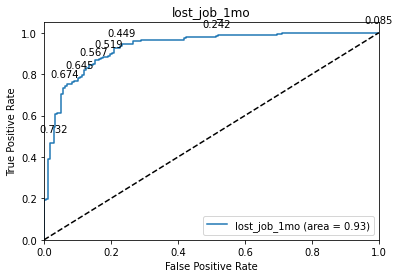

job_search 10
job_search


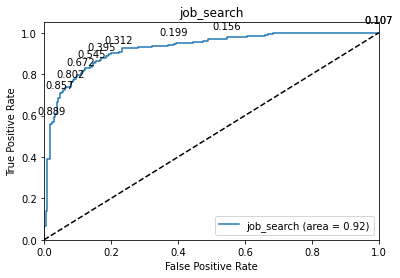

is_hired_1mo 5
is_hired_1mo


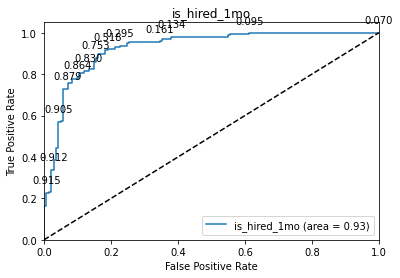

job_offer 15
job_offer


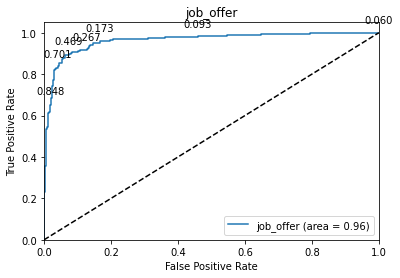

In [7]:
# ROC plot using predicted values on validation set directly i.e. not through validation

import pickle

# with open("./all_pred_8.2.pkl", 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     all_pred = pickle.load(f)
    
def plot_ROC(column, interval):
    
    print(column)
    merged = all_pred[column]
#     print(merged.head())

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_true = merged['class']
    y_pred = merged['pos_model']

#    print(y_true)
    # Compute micro-average ROC curve and ROC area
 
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
#     print('fpr["micro"]', fpr["micro"])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#     print(fpr["micro"])
    
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='{0} (area = {1:0.2f})'
                                   ''.format(column, roc_auc["micro"]))
    count = 0
    for t,x,y in zip(thresholds, fpr["micro"],tpr["micro"]):
#         print(t,x,y)
        count = count + 1

        label = "{:.3f}".format(t)

        if count%interval == 0:
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center'
                    ) # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
         (x,y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0,10), # distance from text to points (x,y)
         ha='center'
        ) # horizontal alignment can be left, right or center
    
    plt.plot([0, 1], [0, 1], 'k--') #line y=x
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.title(column)

    plt.show()    

for column in [ ("is_unemployed",20), 
                 ("lost_job_1mo", 10),
                 ("job_search", 10),
                 ("is_hired_1mo", 5), 
                 ("job_offer", 15) 
              ]:
    print(column[0], column[1])
    plot_ROC(column[0], column[1])
#     plot_ROC('is_unemployed', 10)
    
# merged.head()

is_unemployed
05/20/2020 17:46:02 - INFO - numexpr.utils -   Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
05/20/2020 17:46:02 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.


/scratch/da2734/pyenv_dval_wb_twitter/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars


05/20/2020 17:46:05 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.


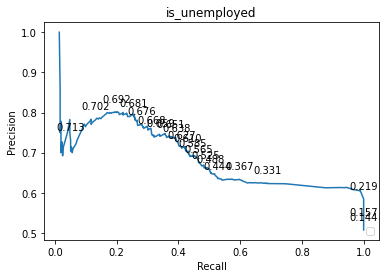

lost_job_1mo


/scratch/da2734/pyenv_dval_wb_twitter/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars


05/20/2020 17:46:06 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.


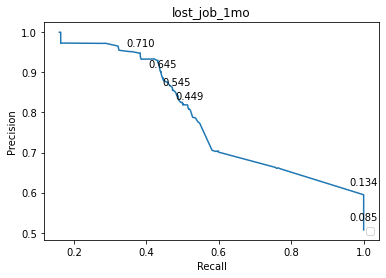

job_search


/scratch/da2734/pyenv_dval_wb_twitter/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars


05/20/2020 17:46:06 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.


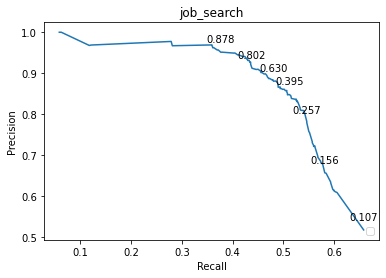

is_hired_1mo


/scratch/da2734/pyenv_dval_wb_twitter/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars


05/20/2020 17:46:07 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.


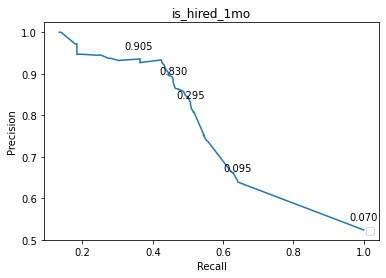

job_offer


/scratch/da2734/pyenv_dval_wb_twitter/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars


05/20/2020 17:46:08 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.


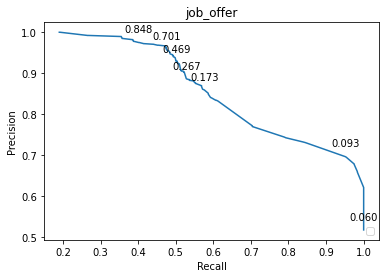

In [8]:
# ROC plot using predicted values on validation set directly i.e. not through validation

import pickle

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:

    print(column)
    results = pd.DataFrame()
    
    merged = all_pred[column]
#     print(merged.head())

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_true = merged['class']
    y_pred = merged['pos_model']

    fpr["micro"], tpr["micro"], threshold_list = roc_curve(y_true.ravel(), y_pred.ravel())
#     print('fpr["micro"]', fpr["micro"])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])    
    
    merged['pos'] = merged['class'] 
    merged['neg'] = abs(1-merged['pos'])
#     print(merged.head())
    
    for threshold in threshold_list:
#         print(threshold)        
        TP = np.sum(merged.loc[merged['pos_model'] > threshold, 'pos'])
        FP = np.sum(merged.loc[merged['pos_model'] > threshold, 'neg'])
        TN = np.sum(merged.loc[merged['neg_model'] < threshold, 'neg'])
        FN = np.sum(merged.loc[merged['neg_model'] < threshold, 'pos'])
    #     TN = np.sum(merged.loc[merged['neg_model'] > threshold, 'neg'])
    #     FN = np.sum(merged.loc[merged['neg_model'] > threshold, 'neg'])

#         total = sum([TP, FP, TN, FN]) 
#     #     print(threshold, TP/total, FP/total, TN/total, FN/total, total)
#         print(column, 'Recall:', str(TP/(TP+FN))[:4],  'Precision', str(TP/(TP+FP))[:4],
#     #           'FPR:', FP/(FP+TN)
#              )

        Recall = TP/(TP+FN)
        Precision = TP/(TP+FP)
        
        results = results.append({'threshold': threshold, 'Recall': Recall, 'Precision': Precision}, ignore_index=True)

    plt.figure()
    plt.plot(results['Recall'], results['Precision'])
    
    count = 0
    for t,x,y in zip(threshold_list, results['Recall'], results['Precision']):
#         print(t,x,y)
        count = count + 1

        label = "{:.3f}".format(t)

        if count%15 == 0 or count == 1:
#             print(count)
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center'
                    ) # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
         (x,y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0,10), # distance from text to points (x,y)
         ha='center'
        ) # horizontal alignment can be left, right or center
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(column)
    plt.legend(loc="lower right")

    plt.show()   
    

#     break
  

# for column in [ ("is_unemployed",15), 
#                  ("lost_job_1mo", 5),
#                  ("job_search", 10),
#                  ("is_hired_1mo", 5), 
#                  ("job_offer", 10) 
#               ]:
# #     print(column[0], column[1])
#     plot_precision_recall(column[0])
#     break
# #     plot_ROC('is_unemployed', 10)
    
# # merged.head()

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


is_unemployed Recall: 0.42 Precision 0.70
lost_job_1mo Recall: 0.47 Precision 0.85
job_search Recall: 0.48 Precision 0.87
is_hired_1mo Recall: 0.45 Precision 0.86
job_offer Recall: 0.50 Precision 0.92


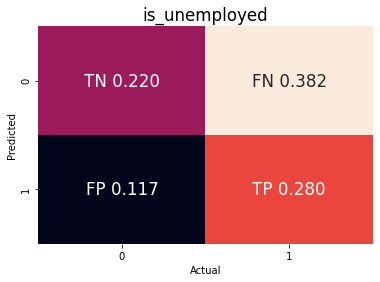

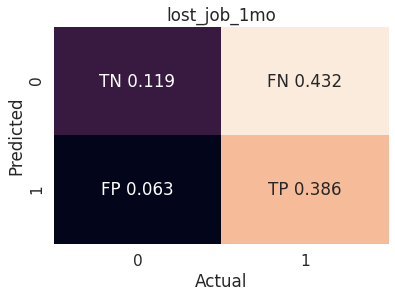

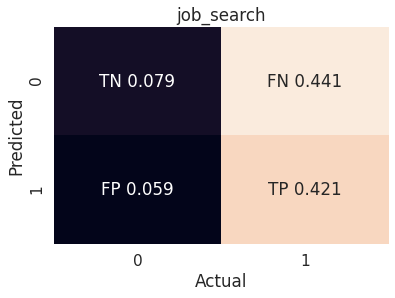

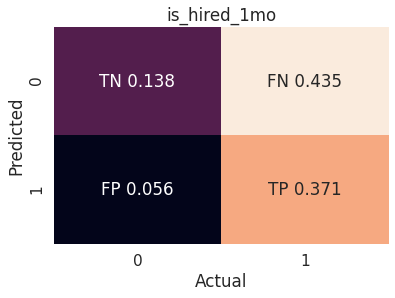

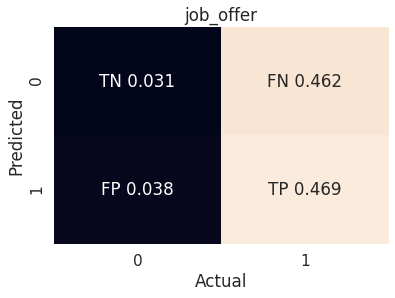

In [9]:
# confusion matrix

import seaborn as sn
from matplotlib.colors import ListedColormap

thresholds_dict = {
    'is_unemployed': 0.617,
    'lost_job_1mo':  0.567,
    'job_search':  0.6,  
    'is_hired_1mo':  0.830,
    'job_offer':     0.469,
}

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
# for column in ["job_offer"]:
    merged = all_pred[column]
    merged['pos'] = merged['class'] 


    merged['neg'] = abs(1-merged['pos'])
#     print(merged.head())
    threshold = thresholds_dict[column]
#     print(threshold)
    
#     print(merged.loc[merged['pos_model'] > 0.9])
    TP = np.sum(merged.loc[merged['pos_model'] > threshold, 'pos'])
    FP = np.sum(merged.loc[merged['pos_model'] > threshold, 'neg'])
    TN = np.sum(merged.loc[merged['neg_model'] < threshold, 'neg'])
    FN = np.sum(merged.loc[merged['neg_model'] < threshold, 'pos'])
#     TN = np.sum(merged.loc[merged['neg_model'] > threshold, 'neg'])
#     FN = np.sum(merged.loc[merged['neg_model'] > threshold, 'neg'])
    
    total = sum([TP, FP, TN, FN]) 
#     print(threshold, TP/total, FP/total, TN/total, FN/total, total)
    print(column, 'Recall:', str(TP/(TP+FN))[:4],  'Precision', str(TP/(TP+FP))[:4],
#           'FPR:', FP/(FP+TN)
         )

    confusion_matrix = np.array([
                                [TN/total, FN/total],
                                [FP/total, TP/total]
                                ])
    labels =           np.array([
                                ['TN', 'FN'],
                                ['FP', 'TP']
                                ])
    
    labels = (np.asarray(["{0} {1:.3f}".format(string, value)
                      for string, value in zip(labels.flatten(),
                                               confusion_matrix.flatten())])
         ).reshape(2, 2)
#     print(labels)
    
    fig, ax = plt.subplots(1)
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(confusion_matrix, annot=labels, fmt="", cbar=False)
    ax.set(xlabel='Actual', ylabel='Predicted')
    plt.title(column)
    
